In [1]:
import numpy as np
import tensorflow
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


In [2]:
class ConvAutoencoder:

  @staticmethod
  def build(width, height, depth, filters=(32,64), latentDim=16):
    input_shape = (width, height, depth)
    chanDim = -1

    inputs = Input(shape=input_shape)
    x = inputs
    for f in filters:
      x = Conv2D(f, (3,3), strides=2, padding='same')(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization()(x)

    # flatten the network and then construct our latent vector
    volumeSize = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latentDim)(x)

    # If you are creating many models in a loop, this global state will consume an increasing amount of memory over time, and you may want to clear it.
    # Calling clear_session() releases the global state
    # K.clear_session()

    encoder = Model(inputs, latent, name='encoder')



    # start building the decoder model which will accept the output of the encoder as its inputs
    latentInputs = Input(shape=(latentDim,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1],volumeSize[2],volumeSize[3]))(x)

    for i in filters[::-1]:
      x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
      x = LeakyReLU(alpha=0.2)(x)
      x = BatchNormalization()(x)


    # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    # build the decoder model
    decoder = Model(latentInputs, outputs, name="decoder")

    # our autoencoder is the encoder + decoder
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    # return a 3-tuple of the encoder, decoder, and autoencoder
    return (encoder, decoder, autoencoder)


In [3]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2



# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

(trainX, _), (testX, _) = mnist.load_data()

trainX = np.expand_dims(trainX, axis=-1).astype("float32") / 255.0
testX = np.expand_dims(testX, axis=-1).astype("float32") / 255.0



encoder, decoder, autoencoder = ConvAutoencoder.build(28, 28, 1)

autoencoder.compile(loss="mse", optimizer="Adam")

H = autoencoder.fit(trainX, trainX,
                    validation_data=(testX, testX),
                    epochs= EPOCHS,
                    batch_size= BS)



11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/25
1875/1875 [==============================] - 25s 6ms/step - loss: 0.0179 - val_loss: 0.0104
Epoch 2/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 3/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 4/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 5/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 6/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 9/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 10

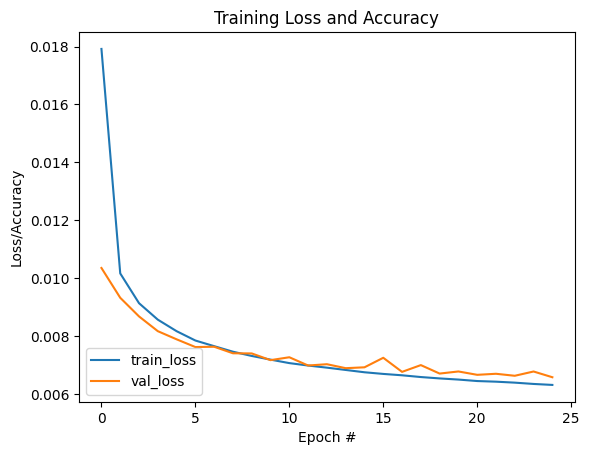

In [6]:
N = np.arange(0, EPOCHS)

plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot')

In [15]:
pred = autoencoder.predict(testX)
pred.shape

313/313 [==============================] - 2s 5ms/step


(10000, 28, 28, 1)

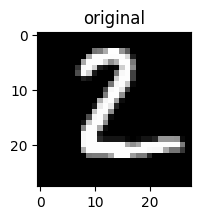

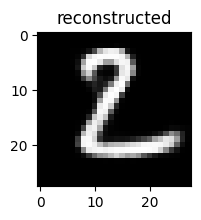

In [35]:
# original
t1 = (testX[1] * 255).astype("uint8")

# reconstructed
p1 = (pred[1]*255).astype("uint8")

plt.figure(figsize=(2,2))
plt.title("original")
plt.imshow(t1, cmap="gray")
plt.figure(figsize=(2,2))
plt.title("reconstructed")
plt.imshow(p1, cmap="gray")